In [1]:
# Add base directory for forestfire project to path to allow use of utils
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

from fastai.vision import *

from sklearn.metrics import classification_report, precision_score, recall_score

import warnings

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
class Precision(Callback):
    
    def on_epoch_begin(self, **kwargs):
        self.correct, self.total = 0, 0
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        preds = last_output.argmax(1)
        self.correct += ((preds==0) * (last_target==0)).float().sum()
        self.total += (preds==0).float().sum()
    
    def on_epoch_end(self, last_metrics, **kwargs):
        return add_metrics(last_metrics, self.correct/self.total)
    
class AUROC(Callback):
    "Computes the area under the curve (AUC) score based on the receiver operator characteristic (ROC) curve. Restricted to binary classification tasks."
    def on_epoch_begin(self, **kwargs):
        self.targs, self.preds = LongTensor([]), Tensor([])
        
    def on_batch_end(self, last_output:Tensor, last_target:Tensor, **kwargs):
        last_output = F.softmax(last_output, dim=1)[:,-1]
        self.preds = torch.cat((self.preds, last_output.cpu()))
        self.targs = torch.cat((self.targs, last_target.cpu().long()))
    
    def on_epoch_end(self, last_metrics, **kwargs):
        return add_metrics(last_metrics, auc_roc_score(self.preds, self.targs))


In [5]:
## To create a ResNET 50 with pretrained weights
def make_learner():
    return cnn_learner(data, models.resnet50, metrics=[accuracy, Precision(), Recall(), FBeta()],
                       callback_fns=[ShowGraph],
                       model_dir="/storage/forestfire/classification_models/").to_fp16()

In [43]:
def pred(df, ds, interval=1000):
    pred_list = []
    print("Predicting", len(ds), "cases...")
    for i in range(len(ds)):
        if i % interval == 0:
            print("Completed", i, "predictions")
        pred_list += [learn.predict(ds[i][0])]
    
    df["patch_pred"] = pd.Series([np.array([pred[2][1]])[0] >= 0.5 for pred in pred_list]).astype(int)
    df["patch_pred_raw"] = [np.array([pred[2][1]])[0] for pred in pred_list]
    df["patch_actual"] = (df["label"] == "smoke").astype(int)


def evaluate_image_level(df, ds, threshold):
    print("Patch level recall:", recall_score(df["patch_actual"], df["patch_pred"]))
    print("Patch level precision:", precision_score(df["patch_actual"], df["patch_pred"]))
    
    image_actual = df.groupby(["ID"])["image_label"].max().reset_index().sort_values(["ID"])["image_label"]
    patch_mean = df.groupby(["ID"])["patch_pred_raw"].mean()
    patch_max = df.groupby(["ID"])["patch_pred_raw"].max()
    image_pred = (df.groupby(["ID"])["patch_pred_raw"].max() >= threshold).astype(int).reset_index(). \
    sort_values(["ID"]).rename({"patch_pred_raw": "image_pred"}, axis=1)["image_pred"]
    
    print("Image level recall:", recall_score(image_actual, image_pred))
    print("Image level precision:", precision_score(image_actual, image_pred))
    
    return pd.DataFrame(zip(image_actual, patch_mean, patch_max), columns=["image_actual", "patch_mean", "patch_max"])

In [7]:
IMAGE_SIZE = (256,256)
IMG_SHAPE = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
BATCH_SIZE = int(128*3/2)
IMAGE_SAMPLE_RATE = 1

In [8]:
# python3 ./fast_patch_generation.py --in_dir /notebooks/storage/forestfire/data/images3/ --out_dir "/root/patches" --workers 8 --s_height 128 --s_width 128 --p_height 128 --p_width 128 --smoke_threshold 0

In [12]:
patch_df = pd.read_parquet("/root/patches/patch_df256x256_256x256_threshold_0.parquet")
patch_df["ID"] = patch_df["original_image_stem"]
patch_df["label"] = (patch_df["smoky_pixel_pct"] >= 0.1).apply(lambda x: "smoke" if x else "no smoke")

train_original_image = pd.read_pickle("../pipeline/train20191215.pickle")[["ID", "label"]].rename({"label": "image_label"}, axis=1)
valid_original_image = pd.read_pickle("../pipeline/validation20191215.pickle")[["ID", "label"]].rename({"label": "image_label"}, axis=1)
test_original_image = pd.read_pickle("../pipeline/test20191215.pickle")[["ID", "label"]].rename({"label": "image_label"}, axis=1)

train_df = patch_df.merge(train_original_image, on=["ID"])
valid_df = patch_df.merge(valid_original_image, on=["ID"])
test_df = patch_df.merge(test_original_image, on=["ID"])

train_df["role"] = "train"
valid_df["role"] = "valid"
test_df["role"] = "test"

patch_df_with_splits = train_df.append(valid_df).append(test_df)
patch_df_with_splits["image_label"] = patch_df_with_splits["image_label"].astype(int)

train_df = patch_df_with_splits[patch_df_with_splits["role"] == "train"].copy()
valid_df = patch_df_with_splits[patch_df_with_splits["role"] == "valid"].copy()
test_df = patch_df_with_splits[patch_df_with_splits["role"] == "test"].copy()

print("Train dataframe has", len(train_df), "observations.")
print("Valid dataframe has", len(valid_df), "observations.")
print("Test dataframe has", len(test_df), "observations.")

Train dataframe has 131528 observations.
Valid dataframe has 43506 observations.
Test dataframe has 44218 observations.


In [13]:
patch_df_with_splits

,original_image_stem,full_image_smoky_pixels,patch_image,patch_mask,smoky_pixel_pct,ID,label,image_label,role
0,ck1uge2i9eyoy0748i976lsmq,157926.0,/root/patches/images/256x256_256x256_threshold...,/root/patches/masks/256x256_256x256_threshold_...,0.000000,ck1uge2i9eyoy0748i976lsmq,no smoke,1,train
1,ck1uge2i9eyoy0748i976lsmq,157926.0,/root/patches/images/256x256_256x256_threshold...,/root/patches/masks/256x256_256x256_threshold_...,0.000000,ck1uge2i9eyoy0748i976lsmq,no smoke,1,train
2,ck1uge2i9eyoy0748i976lsmq,157926.0,/root/patches/images/256x256_256x256_threshold...,/root/patches/masks/256x256_256x256_threshold_...,0.000000,ck1uge2i9eyoy0748i976lsmq,no smoke,1,train
3,ck1uge2i9eyoy0748i976lsmq,157926.0,/root/patches/images/256x256_256x256_threshold...,/root/patches/masks/256x256_256x256_threshold_...,0.000000,ck1uge2i9eyoy0748i976lsmq,no smoke,1,train
4,ck1uge2i9eyoy0748i976lsmq,157926.0,/root/patches/images/256x256_256x256_threshold...,/root/patches/masks/256x256_256x256_threshold_...,0.000000,ck1uge2i9eyoy0748i976lsmq,no smoke,1,train
...,...,...,...,...,...,...,...,...,...
44213,ck1yys5ofbakj0811iuviapnz,1360450.0,/root/patches/images/256x256_256x256_threshold...,/root/patches/masks/256x256_256x256_threshold_...,0.000000,ck1yys5ofbakj0811iuviapnz,no smoke,1,test
44214,ck1yys5ofbakj0811iuviapnz,1360450.0,/root/patches/images/256x256_256x256_threshold...,/root/patches/masks/256x256_256x256_threshold_...,0.037277,ck1yys5ofbakj0811iuviapnz,no smoke,1,test
44215,ck1yys5ofbakj0811iuviapnz,1360450.0,/root/patches/images/256x256_256x256_threshold...,/root/patches/masks/256x256_256x256_threshold_...,0.007004,ck1yys5ofbakj0811iuviapnz,no smoke,1,test
44216,ck1yys5ofbakj0811iuviapnz,1360450.0,/root/patches/images/256x256_256x256_threshold...,/root/patches/masks/256x256_256x256_threshold_...,0.003784,ck1yys5ofbakj0811iuviapnz,no smoke,1,test


In [14]:
tfms = get_transforms(max_rotate=None,
                      max_zoom=1,
#                       max_warp=None
                     )

train_imagelist = ImageList.from_df(train_df, path="/", cols="patch_image").split_none().label_from_df(cols='label')
valid_imagelist = ImageList.from_df(valid_df, path="/", cols="patch_image").split_none().label_from_df(cols='label')
test_imagelist = ImageList.from_df(test_df, path="/", cols="patch_image").split_none().label_from_df(cols='label')

train_imagelist.valid = valid_imagelist.train
train_imagelist.test = test_imagelist.train

data = (train_imagelist.transform(tfms, size=IMAGE_SIZE).databunch(bs=BATCH_SIZE).normalize(imagenet_stats))

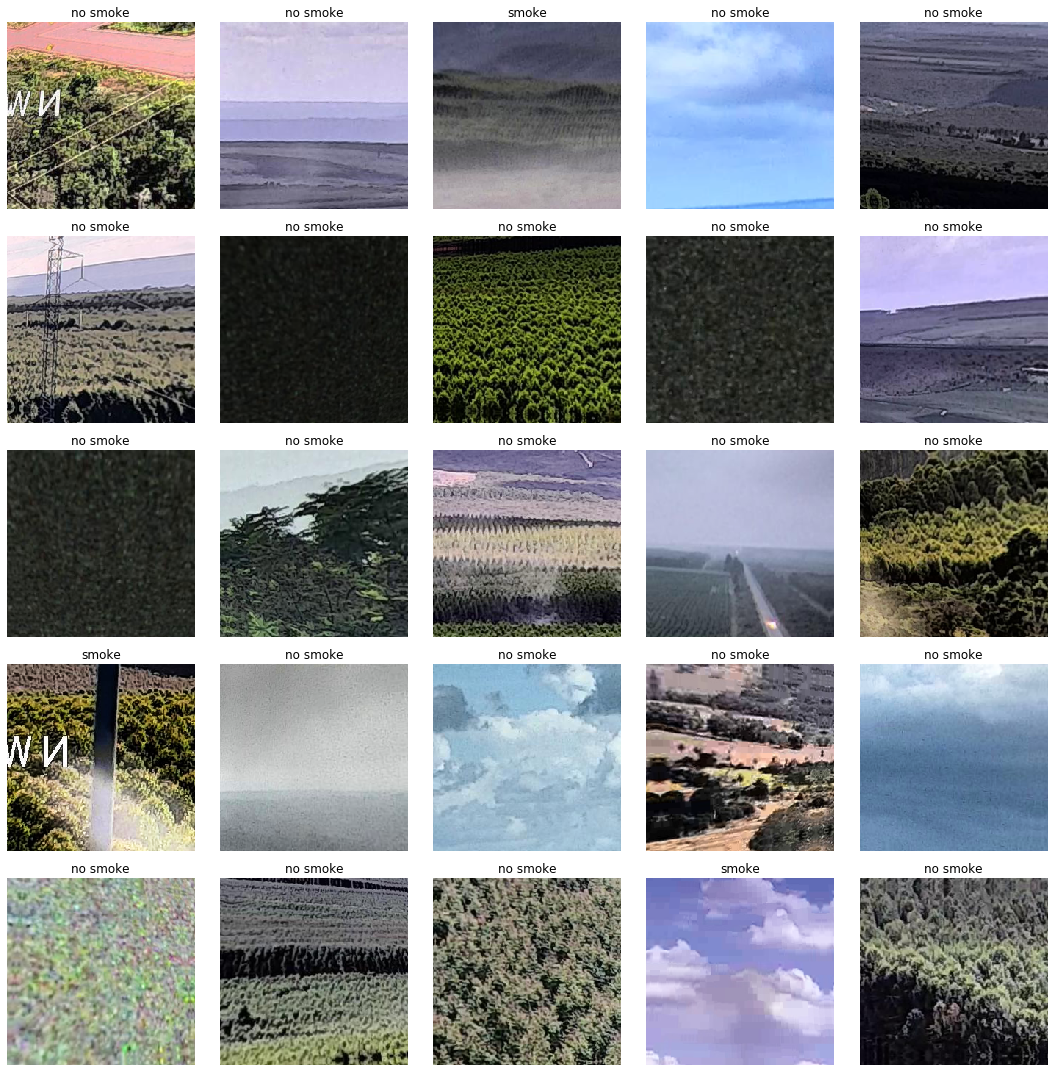

In [15]:
data.show_batch(rows=5, figsize=(15,15))

In [16]:
learn = make_learner()

In [17]:
learn.lr_find(num_it=500)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.45E-07
Min loss divided by 10: 1.34E-02


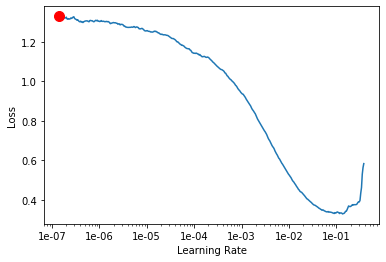

In [18]:
learn.recorder.plot(suggestion=True)

In [19]:
initial_lr = 1.5e-3
initial_epochs = 5

epoch,train_loss,valid_loss,accuracy,precision,recall,f_beta,time
0,0.174425,0.157564,0.943571,0.968949,0.731290,0.730155,10:13
1,0.114539,0.124408,0.951961,0.965403,0.695314,0.716116,10:09
2,0.101009,0.113635,0.956650,0.974533,0.778814,0.782498,10:06
3,0.090218,0.108817,0.957178,0.977746,0.807906,0.803161,10:07
4,0.079806,0.107249,0.958328,0.975430,0.786587,0.790413,10:06


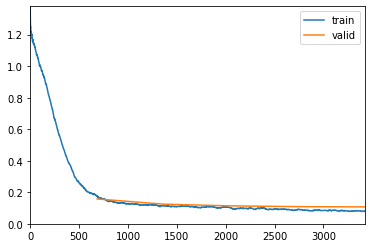

In [20]:
learn.fit_one_cycle(initial_epochs, max_lr=initial_lr)

In [22]:
model_name = "model_" + str(initial_lr) + "_lr_" + str(initial_epochs) + "_epochs"
out_dir = "/storage/forestfire/classification_models/" + model_name

if not os.path.isdir(out_dir):
    os.mkdir(out_dir)

learn.export(file = out_dir + "/export.pkl")
learn.save(model_name, return_path=True)

PosixPath('/storage/forestfire/classification_models/model_0.0015_lr_5_epochs.pth')

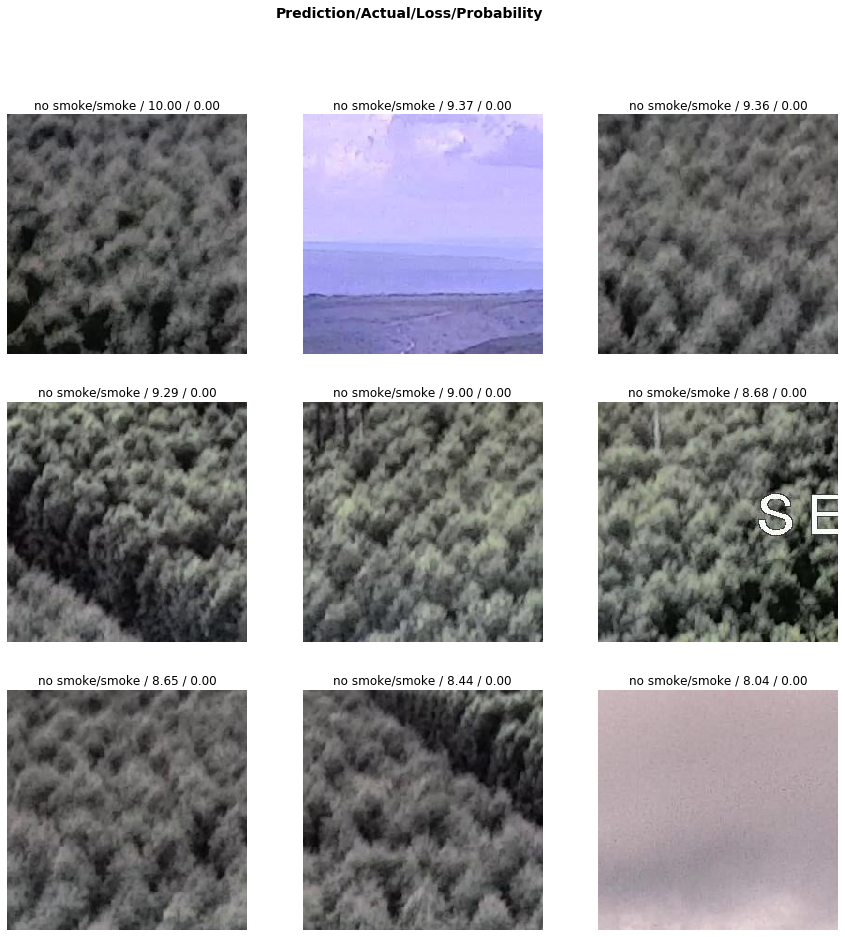

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,15))

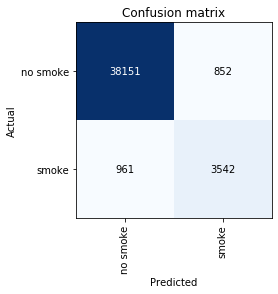

In [24]:
interp.plot_confusion_matrix()

In [25]:
learn = make_learner()
learn.load(model_name);

In [26]:
pred(valid_df, data.valid_ds, 5000)

Predicting 43506 cases...
Completed 0 predictions
Completed 5000 predictions
Completed 10000 predictions
Completed 15000 predictions
Completed 20000 predictions
Completed 25000 predictions
Completed 30000 predictions
Completed 35000 predictions
Completed 40000 predictions


In [55]:
print("Validation Summary Metrics")
image_level_valid_df = evaluate_image_level(valid_df, data.valid_ds, 0.5)

Validation Summary Metrics
Patch level recall: 0.7865867199644682
Patch level precision: 0.8060992262175695
Image level recall: 0.8819095477386935
Image level precision: 0.9397590361445783


In [56]:
print("Validation Summary Metrics")
image_level_valid_df = evaluate_image_level(valid_df, data.valid_ds, 0.15)

Validation Summary Metrics
Patch level recall: 0.7865867199644682
Patch level precision: 0.8060992262175695
Image level recall: 0.9447236180904522
Image level precision: 0.8402234636871508


In [28]:
pred(test_df, data.test_ds, 5000)

Predicting 44218 cases...
Completed 0 predictions
Completed 1000 predictions
Completed 2000 predictions
Completed 3000 predictions
Completed 4000 predictions
Completed 5000 predictions
Completed 6000 predictions
Completed 7000 predictions
Completed 8000 predictions
Completed 9000 predictions
Completed 10000 predictions
Completed 11000 predictions
Completed 12000 predictions
Completed 13000 predictions
Completed 14000 predictions
Completed 15000 predictions
Completed 16000 predictions
Completed 17000 predictions
Completed 18000 predictions
Completed 19000 predictions
Completed 20000 predictions
Completed 21000 predictions
Completed 22000 predictions
Completed 23000 predictions
Completed 24000 predictions
Completed 25000 predictions
Completed 26000 predictions
Completed 27000 predictions
Completed 28000 predictions
Completed 29000 predictions
Completed 30000 predictions
Completed 31000 predictions
Completed 32000 predictions
Completed 33000 predictions
Completed 34000 predictions
Complet

In [61]:
print("Test Summary Metrics")
image_level_test_df = evaluate_image_level(test_df, data.test_ds, 0.5)

Test Summary Metrics
Patch level recall: 0.7856038860675646
Patch level precision: 0.8226589595375723
Image level recall: 0.8697850821744627
Image level precision: 0.91005291005291


In [62]:
print("Test Summary Metrics")
image_level_test_df = evaluate_image_level(test_df, data.test_ds, 0.15)

Test Summary Metrics
Patch level recall: 0.7856038860675646
Patch level precision: 0.8226589595375723
Image level recall: 0.9405815423514539
Image level precision: 0.806941431670282
